In [1]:
#%% Imports
import pandas as pd
import numpy as np
import re
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sentence_transformers import SentenceTransformer
import faiss
import networkx as nx
import matplotlib.pyplot as plt

# For reproducibility
random.seed(42)
np.random.seed(42)

#%% 1. Synthetic Data Generation

def generate_synthetic_data(num_samples=250):
    """
    Generates a synthetic dataset of patient dossiers.
    Each dossier includes subject_id, study_id, file_name, event type, 
    ground truth (XJ_MC), event_subtype, event_onset_date, and dossier_text.
    Some dossiers include clinical keywords to simulate ACS events.
    """
    # Sample keywords from ACS charters (example keywords)
    keywords = ['troponin', 'PCI', 'catheterization', 'chest pain', 'elevated CKMB', 'ST-elevation']
    
    # Some non-keyword sentences
    generic_sentences = [
        "The patient reported a mild headache.",
        "No significant abnormality was detected.",
        "The overall condition is stable.",
        "No previous history of cardiovascular events.",
        "Routine checkup showed normal vital signs."
    ]
    
    # Some sentences that include keywords (simulate positive findings)
    keyword_sentences = [
        f"The lab results showed {random.choice(keywords)} levels were high.",
        f"Following the incident, a {random.choice(keywords)} procedure was performed.",
        f"Patient complained of severe {random.choice(keywords)} and associated symptoms.",
        f"An immediate {random.choice(keywords)} was considered due to the condition."
    ]
    
    data = []
    for i in range(num_samples):
        subject_id = f"S{i+1:05d}"
        study_id = f"Study{random.randint(1,10)}"
        file_name = f"file_{i+1:05d}.pdf"
        event_type = "ACS"
        event_subtype = "SubtypeA"
        # Random date within last 2 years
        event_onset_date = datetime.now() - timedelta(days=random.randint(0, 730))
        
        # Simulate dossier text: randomly pick some generic sentences and occasionally insert keyword sentences.
        num_sentences = random.randint(5, 15)
        sentences = []
        # Decide if this case should be a positive (yes) or negative (no) for EA decision.
        is_positive = random.random() < 0.6  # 60% chance of "yes"
        
        for _ in range(num_sentences):
            if is_positive and random.random() < 0.4:
                sentences.append(random.choice(keyword_sentences))
            else:
                sentences.append(random.choice(generic_sentences))
        
        dossier_text = " ".join(sentences)
        # Ground truth label based on whether keyword sentence is present.
        ground_truth = "yes" if is_positive else "no"
        
        data.append({
            "subject_id": subject_id,
            "study_id": study_id,
            "file_name": file_name,
            "event_type": event_type,
            "XJ_MC": ground_truth,
            "event_subtype": event_subtype,
            "event_onset_date": event_onset_date.strftime("%Y-%m-%d"),
            "dossier_text": dossier_text
        })
    
    return pd.DataFrame(data)

# Generate synthetic data
df = generate_synthetic_data(num_samples=5000)
print("Synthetic data sample:")
print(df.head())



C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Synthetic data sample:
  subject_id study_id       file_name event_type XJ_MC event_subtype  \
0     S00001   Study5  file_00001.pdf        ACS   yes      SubtypeA   
1     S00002   Study7  file_00002.pdf        ACS   yes      SubtypeA   
2     S00003  Study10  file_00003.pdf        ACS   yes      SubtypeA   
3     S00004   Study2  file_00004.pdf        ACS   yes      SubtypeA   
4     S00005  Study10  file_00005.pdf        ACS   yes      SubtypeA   

  event_onset_date                                       dossier_text  
0       2024-06-02  The lab results showed ST-elevation levels wer...  
1       2024-02-25  The overall condition is stable. An immediate ...  
2       2024-07-26  Patient complained of severe troponin and asso...  
3       2023-05-26  No significant abnormality was detected. The o...  
4       2023-12-27  Routine checkup showed normal vital signs. The...  


In [3]:
#%% 2. Preprocessing and Feature Engineering

def clean_text(text):
    """
    Clean and normalize the input text.
    """
    # Lowercase, remove extra spaces and non-alphanumeric characters (except spaces)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Define a keyword list (could be expanded/synonym-expanded later)
clinical_keywords = ['troponin', 'pci', 'catheterization', 'chest pain', 'elevated ckmb', 'stelevation']

def extract_keyword_features(text, keywords=clinical_keywords):
    """
    Extract features based on keyword presence.
    Returns count features and a list of sentences containing keywords.
    """
    cleaned_text = clean_text(text)
    # Split text into sentences (a simple split by period, note: for robust splitting, use nltk.sent_tokenize)
    sentences = re.split(r'\.\s*', cleaned_text)
    
    keyword_count = 0
    evidence_sentences = []
    
    for sentence in sentences:
        for kw in keywords:
            if kw in sentence:
                keyword_count += sentence.count(kw)
                evidence_sentences.append(sentence)
                break  # count a sentence only once even if it has multiple keywords
    
    return keyword_count, evidence_sentences

# Apply preprocessing and feature extraction
df['clean_text'] = df['dossier_text'].apply(clean_text)
df[['keyword_count', 'evidence']] = df['dossier_text'].apply(
    lambda x: pd.Series(extract_keyword_features(x))
)

print("\nAfter feature extraction:")
print(df[['dossier_text', 'keyword_count', 'evidence']].head(1))


After feature extraction:
                                        dossier_text  keyword_count  \
0  The lab results showed ST-elevation levels wer...              1   

                                            evidence  
0  [the lab results showed stelevation levels wer...  


In [7]:
df

,subject_id,study_id,file_name,event_type,XJ_MC,event_subtype,event_onset_date,dossier_text,clean_text,keyword_count,evidence
0,S00001,Study5,file_00001.pdf,ACS,yes,SubtypeA,2024-06-02,The lab results showed ST-elevation levels wer...,the lab results showed stelevation levels were...,1,[the lab results showed stelevation levels wer...
1,S00002,Study7,file_00002.pdf,ACS,yes,SubtypeA,2024-02-25,The overall condition is stable. An immediate ...,the overall condition is stable an immediate s...,2,[the overall condition is stable an immediate ...
2,S00003,Study10,file_00003.pdf,ACS,yes,SubtypeA,2024-07-26,Patient complained of severe troponin and asso...,patient complained of severe troponin and asso...,4,[patient complained of severe troponin and ass...
3,S00004,Study2,file_00004.pdf,ACS,yes,SubtypeA,2023-05-26,No significant abnormality was detected. The o...,no significant abnormality was detected the ov...,4,[no significant abnormality was detected the o...
4,S00005,Study10,file_00005.pdf,ACS,yes,SubtypeA,2023-12-27,Routine checkup showed normal vital signs. The...,routine checkup showed normal vital signs the ...,1,[routine checkup showed normal vital signs the...
...,...,...,...,...,...,...,...,...,...,...,...
4995,S04996,Study8,file_04996.pdf,ACS,yes,SubtypeA,2025-02-05,The overall condition is stable. No significan...,the overall condition is stable no significant...,4,[the overall condition is stable no significan...
4996,S04997,Study5,file_04997.pdf,ACS,yes,SubtypeA,2024-08-19,The lab results showed ST-elevation levels wer...,the lab results showed stelevation levels were...,1,[the lab results showed stelevation levels wer...
4997,S04998,Study6,file_04998.pdf,ACS,no,SubtypeA,2024-05-26,No previous history of cardiovascular events. ...,no previous history of cardiovascular events n...,0,[]
4998,S04999,Study10,file_04999.pdf,ACS,yes,SubtypeA,2023-07-27,The patient reported a mild headache. No previ...,the patient reported a mild headache no previo...,2,[the patient reported a mild headache no previ...


In [9]:
#%% 3. Building a Baseline Classifier and an Ensemble

# For the baseline, we'll use keyword_count as a feature for a logistic regression model.
# We also build a rule-based classifier that simply returns "yes" if keyword_count > 0.

# Prepare features and target
X = df[['keyword_count']]
y = df['XJ_MC'].map({'yes': 1, 'no': 0})  # converting to binary

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred_lr = clf.predict(X_val)
print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, y_pred_lr))
print("F1 score (LR):", f1_score(y_val, y_pred_lr))

# Rule-based classifier function
def rule_based_classifier(keyword_count, threshold=0):
    return 1 if keyword_count > threshold else 0

# Ensemble: simple majority vote between LR and rule-based classifier
def ensemble_predict(row, lr_model):
    pred_lr = lr_model.predict(np.array([[row['keyword_count']]]))[0]
    pred_rule = rule_based_classifier(row['keyword_count'])
    # Majority vote (in this simple case, if both agree, take that; if not, use LR prediction)
    if pred_lr == pred_rule:
        return pred_lr
    else:
        return pred_lr  # or average out; here we favor the learned model

# Apply ensemble prediction on validation set
ensemble_preds = X_val.apply(lambda row: ensemble_predict(row, clf), axis=1)
print("\nEnsemble Classification Report:")
print(classification_report(y_val, ensemble_preds))
print("F1 score (Ensemble):", f1_score(y_val, ensemble_preds))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       402
           1       1.00      0.99      0.99       598

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

F1 score (LR): 0.9949579831932773


C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not h


Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       402
           1       1.00      0.99      0.99       598

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

F1 score (Ensemble): 0.9949579831932773


C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not h

In [10]:
#%% 4. Generating Embeddings and Building a FAISS Index

# Initialize a Sentence Transformer model (using a small model for demo; in practice, consider a biomedical model)
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for each dossier
df['embedding'] = df['clean_text'].apply(lambda x: embedder.encode(x))

# Stack embeddings into a numpy array
embeddings = np.vstack(df['embedding'].values).astype('float32')
d = embeddings.shape[1]

# Build a FAISS index
index = faiss.IndexFlatL2(d)
index.add(embeddings)
print("\nFAISS index built with {} documents.".format(index.ntotal))

# Function to retrieve similar dossiers given a query dossier text
def retrieve_similar_documents(query_text, embedder, index, df, top_k=5):
    query_embedding = embedder.encode(query_text).astype('float32').reshape(1, -1)
    distances, indices = index.search(query_embedding, top_k)
    return df.iloc[indices[0]], distances[0]

# Example retrieval using the first dossier text
query_doc = df.iloc[0]['clean_text']
similar_docs, distances = retrieve_similar_documents(query_doc, embedder, index, df, top_k=5)
print("\nTop similar documents to query:")
print(similar_docs[['subject_id', 'dossier_text']])
print("Distances:", distances)


FAISS index built with 5000 documents.

Top similar documents to query:
     subject_id                                       dossier_text
0        S00001  The lab results showed ST-elevation levels wer...
1775     S01776  The lab results showed ST-elevation levels wer...
2069     S02070  The lab results showed ST-elevation levels wer...
4845     S04846  The lab results showed ST-elevation levels wer...
250      S00251  The lab results showed ST-elevation levels wer...
Distances: [0.         0.03100406 0.03109311 0.03293016 0.03593722]



Knowledge graph nodes and edges:
Nodes: ['troponin', 'stelevation']
Edges: [('troponin', 'stelevation', {'weight': 2216})]


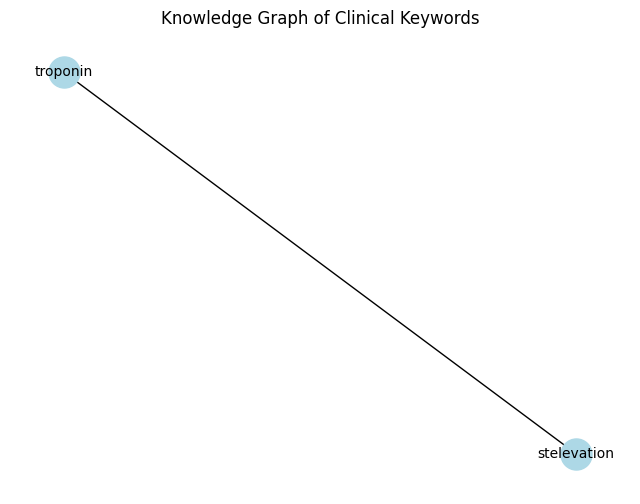

In [11]:
#%% 5. Building a Simple Knowledge Graph with NetworkX

# For each dossier, if two or more clinical keywords appear in the evidence sentences, add an edge between them.
G = nx.Graph()

def add_edges_from_text(text, keywords=clinical_keywords):
    # Find which keywords are present in the text
    present = [kw for kw in keywords if kw in text]
    # Add an edge between every pair of keywords present (undirected graph)
    for i in range(len(present)):
        for j in range(i+1, len(present)):
            if G.has_edge(present[i], present[j]):
                G[present[i]][present[j]]['weight'] += 1
            else:
                G.add_edge(present[i], present[j], weight=1)

# Iterate over each dossier's clean text
for text in df['clean_text']:
    add_edges_from_text(text)

print("\nKnowledge graph nodes and edges:")
print("Nodes:", G.nodes())
print("Edges:", G.edges(data=True))

# Visualize the knowledge graph (optional)
plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
nx.draw_networkx_edges(G, pos, width=1)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Knowledge Graph of Clinical Keywords")
plt.axis('off')
plt.show()

In [12]:
#%% 6. Putting It All Together: End-to-End Prediction Pipeline

def predict_event_adjudication(dossier_text, clf, embedder, index, df_reference):
    """
    For a given dossier text, this function:
    - Cleans and extracts keyword-based features.
    - Generates a prediction from a Logistic Regression model.
    - Retrieves similar cases from the FAISS index.
    - Outputs the rule-based evidence and similar cases as explainability.
    """
    # Preprocess text and extract features
    cleaned = clean_text(dossier_text)
    keyword_count, evidence_sentences = extract_keyword_features(dossier_text)
    
    # Prediction from classifier
    lr_pred = clf.predict(np.array([[keyword_count]]))[0]
    pred_label = "yes" if lr_pred == 1 else "no"
    
    # Retrieve similar cases
    similar_docs, distances = retrieve_similar_documents(cleaned, embedder, index, df_reference, top_k=3)
    
    result = {
        "prediction": pred_label,
        "keyword_count": keyword_count,
        "evidence_sentences": evidence_sentences,
        "similar_documents": similar_docs[['subject_id', 'dossier_text']].to_dict(orient='records'),
        "similarity_distances": distances.tolist()
    }
    return result

# Example usage:
sample_text = df.iloc[10]['dossier_text']
result = predict_event_adjudication(sample_text, clf, embedder, index, df)
print("\nEnd-to-End Prediction Result:")
print(result)



End-to-End Prediction Result:
{'prediction': 'yes', 'keyword_count': 2, 'evidence_sentences': ['no previous history of cardiovascular events an immediate stelevation was considered due to the condition patient complained of severe troponin and associated symptoms the lab results showed stelevation levels were high routine checkup showed normal vital signs patient complained of severe troponin and associated symptoms an immediate stelevation was considered due to the condition routine checkup showed normal vital signs the lab results showed stelevation levels were high the patient reported a mild headache no significant abnormality was detected'], 'similar_documents': [{'subject_id': 'S00011', 'dossier_text': 'No previous history of cardiovascular events. An immediate ST-elevation was considered due to the condition. Patient complained of severe troponin and associated symptoms. The lab results showed ST-elevation levels were high. Routine checkup showed normal vital signs. Patient com

C:\Users\Ravi Kiran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [14]:
from transformers import AutoTokenizer, AutoModel

# Use the correct model identifier with the hyphen
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/clinical-bert")
model = AutoModel.from_pretrained("emilyalsentzer/clinical-bert")


OSError: emilyalsentzer/clinical-bert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`